In [1]:
import pandas as pds
import numpy as np
import textdistance
import timeit
import math
import statsmodels.api as sm
import scipy
from patsy import dmatrix
import time
import math
import tqdm
import os
from matplotlib import pyplot as plt

In [2]:
name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)

identifiers = {'family_name':'jaro-winkler','was_assigned_female':'strict','country':'strict','birth_year':'large'}
covariates = ['X1','X2','X3','X4','X5']

In [3]:
########## GENERATES ASSOCIATION ##########           

# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
a = 5.5
b = 0.01
c = 0.08
d = 0.7

ate = a * 2.5
DF['Y'] = - 10 + a*DF['treatment']*DF['X2'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] 


In [4]:
common_records = DF.sample(n = 800)

B = pds.concat([DF.sample(n = 1400), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.sample(n = 2000), common_records])[list(identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

In [5]:
def levenshtein_similarity(a,b):

    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):

    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):

    """ Check that a and b values are equal.
        
        a: any value,
        b: any value """

    return a==b

def large_equality(a,b):

    """ Check that years a and b expressed with four numbers are within the same decade.
        
        a: year,
        b: year """

    return str(a)[:-1]==str(b)[:-1]

def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    
def propensity_score(DF, covariates, scaler, convert_to_logit):
    
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = covariates.copy()
    if scaler != None:
        DF[exog] = scaler(DF[exog])
    if 'intercept' not in DF.columns:
        DF['intercept'] = 1
    exog.append('intercept')
    model = sm.Logit(DF.treatment, DF[exog]).fit(disp=0)
    predictions = model.predict(DF[exog])
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

In [6]:
AB = B.merge(A, how='cross')
AB["source_index_B"] = np.repeat(B.index, A.shape[0])
AB["source_index_A"] = np.tile(A.index, B.shape[0])
AB

,name,family_name_x,country_x,birth_year_x,was_assigned_female_x,X1,X2,X3,X4,X5,treatment,family_name_y,was_assigned_female_y,country_y,birth_year_y,Y,source_index_B,source_index_A
0,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,0,Ellerington,0,GB,1982,-12.140245,0,0
1,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,0,Shelton,1,GB,1957,-8.198515,0,1
2,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,0,Dorofeeva,1,RU,1955,-1.731686,0,2
3,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,0,Wagner,0,NL,1999,-10.772816,0,3
4,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,0,Wardzała,0,PL,1970,-5.692543,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159995,Mirjana,Stankovic,RS,1998,1,22,0.032929,-0.163625,-0.676903,0.932684,1,Mulack,0,DE,1995,-12.525451,2199,2795
6159996,Mirjana,Stankovic,RS,1998,1,22,0.032929,-0.163625,-0.676903,0.932684,1,Müller,0,AT,1972,-7.666611,2199,2796
6159997,Mirjana,Stankovic,RS,1998,1,22,0.032929,-0.163625,-0.676903,0.932684,1,Di Riccio,0,IT,2013,-10.106473,2199,2797
6159998,Mirjana,Stankovic,RS,1998,1,22,0.032929,-0.163625,-0.676903,0.932684,1,Sanchez,1,ES,1954,-13.690015,2199,2798


In [7]:
methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = AB.filter(regex=linking_var)
    AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparison_vectors_only = AB.filter(regex="comparison")

unmatch = np.array(comparison_vectors_only.sum(axis=0) / len(comparison_vectors_only)) # probability of having same linking var (at all)
match = np.repeat(0.95, len(identifiers.keys())) # probability of having same linking var when being matches

AB["linking_score"] = (np.multiply(comparison_vectors_only, np.log2(match/unmatch)) + np.multiply(1-comparison_vectors_only, np.log2((1-match)/(1-unmatch)))).sum(axis=1)
AB['propensity_score'] = propensity_score(AB, covariates, None, False)
AB

,name,family_name_x,country_x,birth_year_x,was_assigned_female_x,X1,X2,X3,X4,X5,...,Y,source_index_B,source_index_A,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,linking_score,intercept,propensity_score
0,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,...,-12.140245,0,0,0,1,0,1,-4.865795,1,0.077754
1,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,...,-8.198515,0,1,0,0,0,0,-15.883013,1,0.077754
2,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,...,-1.731686,0,2,0,0,0,0,-15.883013,1,0.077754
3,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,...,-10.772816,0,3,0,1,0,0,-11.640484,1,0.077754
4,Leonardo,Pantoja Aguilera,ES,1981,0,39,4.692437,-0.072021,2.007894,1.268998,...,-5.692543,0,4,0,1,0,0,-11.640484,1,0.077754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159995,Mirjana,Stankovic,RS,1998,1,22,0.032929,-0.163625,-0.676903,0.932684,...,-12.525451,2199,2795,0,0,0,1,-9.108324,1,0.039322
6159996,Mirjana,Stankovic,RS,1998,1,22,0.032929,-0.163625,-0.676903,0.932684,...,-7.666611,2199,2796,0,0,0,0,-15.883013,1,0.039322
6159997,Mirjana,Stankovic,RS,1998,1,22,0.032929,-0.163625,-0.676903,0.932684,...,-10.106473,2199,2797,0,0,0,0,-15.883013,1,0.039322
6159998,Mirjana,Stankovic,RS,1998,1,22,0.032929,-0.163625,-0.676903,0.932684,...,-13.690015,2199,2798,0,1,0,0,-11.640484,1,0.039322


In [8]:
comparison_vectors_only

,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison
0,0,1,0,1
1,0,0,0,0
2,0,0,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
6159995,0,0,0,1
6159996,0,0,0,0
6159997,0,0,0,0
6159998,0,1,0,0


In [9]:
where_good_comparisons = AB[comparison_vectors_only.all(axis=1)]

# remove duplicata: 
where_good_comparisons = where_good_comparisons[ (~where_good_comparisons.source_index_A.duplicated(keep=False)) & (~where_good_comparisons.source_index_B.duplicated(keep=False)) ]
where_good_comparisons

,name,family_name_x,country_x,birth_year_x,was_assigned_female_x,X1,X2,X3,X4,X5,...,Y,source_index_B,source_index_A,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,linking_score,intercept,propensity_score
15965,Pablo,Quejigo Sanchez-Guijaldo,ES,1981,0,39,1.872724,-0.590046,1.602619,0.645198,...,-11.339644,5,1965,1,1,1,1,17.986292,1,0.041952
16874,Tamás,Stein,HU,2010,0,10,2.882410,-0.094059,0.916818,1.888200,...,7.124761,6,74,1,1,1,1,17.986292,1,0.300246
32105,Кристина,Иванова,RU,1955,1,65,1.327448,-0.209474,2.028906,1.065008,...,-10.267703,11,1305,1,1,1,1,17.986292,1,0.002500
39927,Marc,Helmstedt,DE,2015,0,5,2.438209,-0.871638,0.034779,0.711052,...,3.569585,14,727,1,1,1,1,17.986292,1,0.458744
46535,Joël,Masse,FR,1978,0,42,1.579975,-0.799582,0.061675,0.650069,...,-12.220911,16,1735,1,1,1,1,17.986292,1,0.016155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6137591,Света,Федорова,RU,2018,1,2,1.640018,0.026614,2.093515,1.117895,...,-9.132082,2191,2791,1,1,1,1,17.986292,1,0.583117
6140392,Eduart,Muçaj,AL,1948,0,72,3.018400,-0.133854,1.505993,1.667673,...,-9.558542,2192,2792,1,1,1,1,17.986292,1,0.001301
6143193,Magnus,Wessén,SE,2019,0,1,3.218967,0.739057,-1.074466,0.303198,...,7.979095,2193,2793,1,1,1,1,17.986292,1,0.433603
6148795,Steffen,Mulack,DE,1995,0,25,2.100075,-1.274984,1.190283,-0.011946,...,-12.525451,2195,2795,1,1,1,1,17.986292,1,0.201209


In [10]:
# create linked_records
# create z0
# look at true linkage

idx_A = where_good_comparisons.source_index_A
idx_B = where_good_comparisons.source_index_B

from_A = A.iloc[idx_A,:].reset_index(drop=True)
from_B = B.iloc[idx_B,:].reset_index(drop=True)

linked_records = pds.concat([from_B, from_A.Y], axis=1)
linked_records['propensity_score'] = propensity_score(linked_records, covariates, None, False)

z0 = -np.ones(B.shape[0])
z0[idx_B] = idx_A

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-800:,:].index] = A.iloc[-800:,:].index

In [11]:
z0

array([-1.000e+00, -1.000e+00, -1.000e+00, ...,  2.797e+03, -1.000e+00,
       -1.000e+00])

In [12]:
true_linkage_z

array([-1.000e+00, -1.000e+00, -1.000e+00, ...,  2.797e+03,  2.798e+03,
        2.799e+03])

In [13]:
(z0==true_linkage_z).sum()/len(z0)

0.5068181818181818

In [14]:
# INITIALISATION

z_k = [z0.copy()]
linked_records_k = [linked_records.copy()]

def update_linkage_param(cartesian_product_AB, previous_z):

    idx_A = previous_z[previous_z>=0]
    idx_B = np.nonzero(previous_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
    pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

    data_match = cartesian_product_AB[pairs.isin(links)]
    comparisons_match = data_match.filter(regex="comparison")
    new_theta_m = scipy.stats.beta.rvs(comparisons_match.sum(axis=0) + 1, (1-comparisons_match).sum(axis=0) + 1)

    data_unmatch = cartesian_product_AB[(~pairs.isin(links)) & (~cartesian_product_AB.source_index_B.duplicated()) & (~cartesian_product_AB.source_index_A.duplicated())]
    # REMARK: we also filtered on duplicata, otherwise data_unmatch is considering too many data and probabilities are too small
    
    comparisons_unmatch = data_unmatch.filter(regex="comparison")
    new_theta_u = scipy.stats.beta.rvs(comparisons_unmatch.sum(axis=0) + 1, (1-comparisons_unmatch).sum(axis=0) + 1)

    return new_theta_m, new_theta_u

theta_m_k = [match.copy()]
theta_u_k = [unmatch.copy()]

# build thetas:
new_theta_m, new_theta_u = update_linkage_param(AB, z_k[-1])
theta_m_k.append(new_theta_m)
theta_u_k.append(new_theta_u)

def update_unmatched_outcome_param(file_A, previous_z, previous_mu2, previous_sigma2_square, previous_a_sigma2, previous_b_sigma2):

    idx_A = previous_z[previous_z>=0]

    n_AB = (previous_z>=0).sum()
    
    non_linked_outcomes = file_A.iloc[~file_A.index.isin(idx_A),:].Y

    new_sigma2_square = scipy.stats.invgauss.rvs(previous_a_sigma2 + (file_A.shape[0]-n_AB)/2, previous_b_sigma2 + ((non_linked_outcomes - previous_mu2)**2 / 2).sum())
    sigma_mu_2_square = 1 / ((file_A.shape[0] -  n_AB)/previous_sigma2_square + 1)
    m_mu_2 = sigma_mu_2_square * (non_linked_outcomes).sum() / previous_sigma2_square
    
    new_mu2 = scipy.stats.norm.rvs(m_mu_2, np.sqrt(sigma_mu_2_square))

    return new_mu2, new_sigma2_square

a_sigma2_k = [1]
b_sigma2_k = [1]

mu2_k = [scipy.stats.norm.rvs(0,1)]
sigma2_square_k = [scipy.stats.invgauss.rvs(a_sigma2_k[-1],b_sigma2_k[-1])]

new_mu2, new_sigma2_square = update_unmatched_outcome_param(A, z_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
mu2_k.append(new_mu2)
sigma2_square_k.append(new_sigma2_square)

def update_matched_outcome_param(cartesian_product_AB, previous_z, previous_linked_records, previous_beta0, previsou_beta1, previous_alpha, previous_sigma_square, previous_a_sigma, previous_b_sigma):

    idx_A = previous_z[previous_z>=0]
    idx_B = np.nonzero(previous_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
    pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

    tilde_y = previous_linked_records.Y
    tilde_K = np.array([previous_linked_records.intercept, previous_linked_records.propensity_score, previous_linked_records.treatment]).T

    sigma_matrix = np.linalg.inv( tilde_K.T @ tilde_K / previous_sigma_square + np.eye(tilde_K.shape[1]) )
    tilde_K.T @ tilde_y
    mu_vector = sigma_matrix @ tilde_K.T @ tilde_y / previous_sigma_square
    new_beta0, new_beta1, new_alpha = scipy.stats.multivariate_normal.rvs(mu_vector, sigma_matrix)

    n_AB = (previous_z>=0).sum()
    new_sigma_square = scipy.stats.invgauss.rvs(previous_a_sigma + n_AB/2, np.linalg.norm(tilde_y - tilde_K @ np.array([previous_beta0, previsou_beta1, previous_alpha]))**2 / 2 + previous_b_sigma)
    
    return new_beta0, new_beta1, new_alpha, new_sigma_square

a_sigma_k = [1]
b_sigma_k = [1]

beta0_k = [scipy.stats.norm.rvs(0,1)]
beta1_k = [scipy.stats.norm.rvs(0,1)]
alpha_k = [scipy.stats.norm.rvs(0,1)]
sigma_square_k = [scipy.stats.invgauss.rvs(a_sigma_k[-1],b_sigma_k[-1])]

new_beta0, new_beta1, new_alpha, new_sigma_square = update_matched_outcome_param(AB, z_k[-1], linked_records_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1])
beta0_k.append(new_beta0)
beta1_k.append(new_beta1)
alpha_k.append(new_alpha)
sigma_square_k.append(new_sigma_square)

In [28]:
### UPDATE Z ###

# update linkage z_j

new_z = []
file_AB = AB.copy()
file_B = B.copy()
file_A = A.copy()

theta_m = theta_m_k[-1]
theta_u = theta_u_k[-1]
mu2 = mu2_k[-1]
sigma2_square = sigma2_square_k[-1]

beta0 = beta0_k[-1]
beta1 = beta1_k[-1]
alpha = alpha_k[-1]

z = z_k[-1]
alpha_pi_k = [1]
beta_pi_k = [1]
beta_pi = beta_pi_k[-1]
alpha_pi = alpha_pi_k[-1]

already_taken = []

for fixed_j in range(file_B.shape[0]):

    comparison_for_j = comparison_vectors_only[file_AB.source_index_B==fixed_j].copy()

    w1 = ( np.multiply( comparison_for_j, np.log(theta_m/theta_u) ) + np.multiply( 1-comparison_for_j, np.log((1-theta_m)/(1-theta_u)) ) ).sum(axis=1)

    w2_unmatched_outcome = scipy.stats.norm.pdf(file_AB[file_AB.source_index_B==fixed_j].Y, mu2, np.sqrt(sigma2_square))

    data_for_j = file_AB[file_AB.source_index_B==fixed_j].copy()
    residuals = data_for_j.Y - np.array([data_for_j.intercept, data_for_j.propensity_score, data_for_j.propensity_score * data_for_j.treatment]).T @ np.array([beta0, beta1, alpha]).T
    residuals_variance = residuals.T @ residuals / (len(residuals) - (3+1))

    w2_matched_outcome = scipy.stats.norm.pdf(residuals, 0, np.sqrt(residuals_variance))

    w2 = np.log(w2_matched_outcome/w2_unmatched_outcome)

    probabilities = np.array(np.exp(w1+w2))

    choice_array = list(filter(lambda x: x not in already_taken, np.arange(file_A.shape[0])))
    probabilities = probabilities[choice_array]

    choice_array = np.append(choice_array, -1)
    others = np.delete(z, fixed_j)
    n_AB_ = (others>=0).sum()
    proba_no_link = (file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
    probabilities = np.append(probabilities, proba_no_link)
    
    val = np.random.choice(choice_array, p = probabilities / sum(probabilities))
    if val != -1:
        already_taken.append(val)
    
    new_z.append(val)

print(new_z)


[-1, -1, 2382, -1, 2691, 1965, 74, -1, -1, -1, 977, 1305, -1, -1, 727, 1953, 2205, 956, -1, -1, -1, -1, -1, -1, 793, 1016, -1, 1363, -1, 342, -1, -1, 1384, -1, 2633, 2538, -1, 1283, 2243, 429, -1, -1, -1, 2297, 200, -1, -1, 1566, 1715, -1, 332, 2608, 331, -1, 804, -1, 872, -1, -1, 881, -1, 1782, 2120, -1, 2477, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 566, 471, 71, -1, 565, -1, 1082, -1, -1, 2039, 2059, -1, 469, 1249, -1, 1485, 1531, -1, 1187, 2730, 639, -1, 135, -1, 1525, 1141, 2599, 1178, 2299, -1, -1, -1, 2757, 1579, -1, -1, 781, -1, -1, 147, 2181, 601, 676, -1, -1, -1, 2275, 747, -1, -1, 1950, -1, -1, -1, -1, 1963, 885, -1, -1, 2190, 1255, -1, -1, -1, -1, 2216, 2625, -1, -1, 2389, -1, -1, -1, -1, -1, 1155, 2184, 1846, 1863, 2069, -1, -1, 361, 217, -1, -1, 1216, 633, -1, -1, -1, -1, -1, -1, 1302, 2364, -1, -1, 1256, 425, -1, -1, -1, 2591, 1308, 2146, -1, -1, 2758, -1, 1480, -1, -1, -1, -1, -1, -1, -1, 158, 743, -1, 2442, -1, -1, 2085, 1015, 1881, -1, -1, 1242, 1156, -1, -1, 1982, 122

In [27]:
### UPDATE Z ### OPTI NEW

# update linkage z_j

new_z = []
file_AB = AB.copy()
file_B = B.copy()
file_A = A.copy()

theta_m = theta_m_k[-1]
theta_u = theta_u_k[-1]
mu2 = mu2_k[-1]
sigma2_square = sigma2_square_k[-1]

beta0 = beta0_k[-1]
beta1 = beta1_k[-1]
alpha = alpha_k[-1]

z = z_k[-1]
alpha_pi_k = [1]
beta_pi_k = [1]
beta_pi = beta_pi_k[-1]
alpha_pi = alpha_pi_k[-1]

already_taken = []

comparison_vectors = comparison_vectors_only.copy()
w1 = ( np.multiply( comparison_vectors, np.log(theta_m/theta_u) ) + np.multiply( 1-comparison_vectors, np.log((1-theta_m)/(1-theta_u)) ) ).sum(axis=1)
w2_unmatched_outcome = scipy.stats.norm.pdf(file_AB.Y, mu2, np.sqrt(sigma2_square))
X = np.array([file_AB.intercept, file_AB.propensity_score, file_AB.propensity_score * file_AB.treatment]).T
BETA = np.array([beta0, beta1, alpha]).T
residuals = file_AB.Y - X @ BETA
# REMARK: X  in the residuals computation never evolve since we are using cartesian_product_AB file with all "potential links"
residuals_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
w2_matched_outcome = scipy.stats.norm.pdf(residuals, 0, np.sqrt(residuals_variance))
w2 = np.log(w2_matched_outcome/w2_unmatched_outcome)
probabilities = np.array(np.exp(w1+w2))
probabilities = probabilities.reshape(file_B.shape[0], file_A.shape[0])

n_AB_ = np.array([ (np.delete(z, j)>=0).sum() for j in range(file_B.shape[0]) ])

proba_no_link = (file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
proba_no_link = proba_no_link.reshape(-1,1)

#print(probabilities.shape)

for fixed_j in range(file_B.shape[0]):

    proba_vector = probabilities[fixed_j,:]
    #print(proba_no_link[fixed_j,:])

    choice_array = list(filter(lambda x: x not in already_taken, np.arange(file_A.shape[0])))
    proba_vector = proba_vector[choice_array]

    #print(len(choice_array), len(proba_vector))

    choice_array = np.append(choice_array, -1)
    #others = np.delete(z, fixed_j)
    #n_AB_ = (others>=0).sum()
    # proba_no_link = (file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
    proba_vector = np.append(proba_vector, proba_no_link[fixed_j,:])
    #print(proba_vector)
    #
    #proba_vector = np.concatenate([probabilities, proba_no_link], axis = 1)
    proba_vector = proba_vector / proba_vector.sum() #np.divide(proba_vector.T, proba_vector.sum(axis=1)).T
    
    val = np.random.choice(choice_array, p = proba_vector)
    if val != -1:
        already_taken.append(val)
    
    new_z.append(val)

print(new_z)

[-1, -1, 2382, -1, 2691, 1965, -1, -1, -1, -1, 977, 1305, 2359, -1, -1, 1953, 1735, 956, 2046, -1, -1, -1, 1240, -1, 793, -1, -1, 1363, -1, 342, -1, -1, 1384, 1852, -1, -1, -1, 1283, 131, 429, -1, -1, 2066, 2297, -1, 1264, -1, -1, 1715, -1, 332, 2608, 331, -1, -1, -1, 872, -1, -1, 881, -1, 1782, 816, -1, -1, 1182, -1, -1, -1, -1, -1, 2728, 1103, 495, -1, 566, 471, -1, -1, 565, -1, 1082, -1, -1, 2039, 2059, -1, 469, 1249, -1, 1485, 1531, -1, 1187, 399, 639, 1804, -1, -1, 1525, 1141, 445, -1, -1, -1, -1, 874, 638, 1579, 1713, -1, -1, -1, -1, 147, 2181, -1, 676, -1, -1, -1, 2275, -1, 821, -1, 2238, -1, 652, 65, -1, -1, 885, 1719, -1, -1, 1255, -1, -1, 2624, -1, 2216, 2625, -1, -1, 2389, -1, -1, -1, -1, -1, 1155, 2184, 1846, -1, 1277, -1, -1, 361, 217, -1, -1, -1, 633, -1, -1, 46, -1, -1, -1, -1, 2364, 654, -1, 1256, 425, -1, 11, -1, 2591, 1308, 2146, -1, -1, -1, -1, -1, -1, -1, -1, -1, 949, 2492, -1, -1, 743, -1, 2442, -1, 522, 384, 1015, 1881, -1, -1, 1242, -1, -1, -1, -1, 1221, 2593, -1

In [37]:
### UPDATE Z ### ### OPTIMIZE !!! ###

# update linkage z_j

new_z = []
file_AB = AB.copy()
file_B = B.copy()
file_A = A.copy()

theta_m = theta_m_k[-1]
theta_u = theta_u_k[-1]
mu2 = mu2_k[-1]
sigma2_square = sigma2_square_k[-1]

beta0 = beta0_k[-1]
beta1 = beta1_k[-1]
alpha = alpha_k[-1]

z = z_k[-1]
alpha_pi_k = [1]
beta_pi_k = [1]
beta_pi = beta_pi_k[-1]
alpha_pi = alpha_pi_k[-1]

already_taken = []

comparison_vectors = comparison_vectors_only.copy()

#for fixed_j in range(file_B.shape[0]):

    #print(fixed_j)

    #fixed_j = 3

w1 = ( np.multiply( comparison_vectors, np.log(theta_m/theta_u) ) + np.multiply( 1-comparison_vectors, np.log((1-theta_m)/(1-theta_u)) ) ).sum(axis=1)

w2_unmatched_outcome = scipy.stats.norm.pdf(file_AB.Y, mu2, np.sqrt(sigma2_square))

X = np.array([file_AB.intercept, file_AB.propensity_score, file_AB.propensity_score * file_AB.treatment]).T
BETA = np.array([beta0, beta1, alpha]).T
residuals = file_AB.Y - X @ BETA
# REMARK: X  in the residuals computation never evolve since we are using cartesian_product_AB file with all "potential links"
residuals_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))

w2_matched_outcome = scipy.stats.norm.pdf(residuals, 0, np.sqrt(residuals_variance))

w2 = np.log(w2_matched_outcome/w2_unmatched_outcome)

probabilities = np.array(np.exp(w1+w2))
probabilities = probabilities.reshape(file_B.shape[0], file_A.shape[0])

#print("proba shape", probabilities.shape)

n_AB_ = np.array([ (np.delete(z, j)>=0).sum() for j in range(file_B.shape[0]) ])
#print(n_AB_)
#print("choice shape", choice_array.shape)

proba_no_link = (file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
#print(proba_no_link)
#print(proba_no_link.reshape(-1,1))
proba_no_link = proba_no_link.reshape(-1,1)
#print("proba no shape", proba_no_link.shape)
probabilities = np.concatenate([probabilities, proba_no_link], axis = 1)
#print("proba shape", probabilities.shape)

for fixed_j in range(file_B.shape[0]):
    
    choice_array = list(filter(lambda x: x not in already_taken, np.arange(A.shape[0])))
    choice_array = np.append(choice_array, -1)
    choice_array = np.tile(choice_array, file_B.shape[0]).reshape(file_B.shape[0], file_A.shape[0]+1)

    probabilities = probabilities[:,choice_array]
    proba_vector = np.divide(probabilities.T, probabilities.sum(axis=1)).T

    val = np.random.choice(choice_array[fixed_j,:], p = proba_vector[fixed_j,:])
    if val != -1:
        already_taken.append(val)
    new_z.append(val)

print(new_z)

# probabilities = np.concatenate([probabilities, proba_no_link], axis=1)

#     choice_array = np.arange(file_A.shape[0])
#     choice_array = np.append(choice_array, -1)
#     choice_array = np.tile(choice_array, file_B.shape[0]).reshape(file_B.shape[0], file_A.shape[0]+1)

    


: 

: 

In [35]:
np.unique(np.array(new_z), return_counts=True)

(array([  -1,    3,    7, ..., 2797, 2798, 2799]),
 array([816,   1,   1, ...,   1,   1,   2]))

In [ ]:
proba_no_link = (file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
probabilities = np.concatenate([probabilities, proba_no_link], axis = 1)
print("proba shape", probabilities.shape)

In [28]:
print(proba_no_link.reshape(-1,1).shape)

(2200, 1)


In [16]:
choice_array = np.tile(choice_array, file_B.shape[0])

In [17]:
choice_array.shape

(4402200,)

In [20]:
# TODO revoir parametres initiaux!!!
# 
# 
print(z_k[-1])

print(linked_records_k[-1])

print(theta_m_k[-1])

print(theta_u_k[-1])

print(alpha_pi_k[-1])
print(beta_pi_k[-1])

print(a_sigma_k[-1])
print(b_sigma_k [-1])

print(a_sigma2_k[-1])
print(b_sigma2_k[-1])

print(beta0_k[-1])
print(beta1_k[-1])
print(alpha_k[-1])
print(sigma_square_k[-1])

print(mu2_k[-1])
print(sigma2_square_k[-1])

[-1.000e+00  1.579e+03 -1.000e+00 ... -1.000e+00 -1.000e+00  2.799e+03]
              name       family_name country  birth_year  was_assigned_female  \
0        Francesco            Leggio      NL        1941                    0   
1        Francesca           Melillo      IT        1957                    1   
2            Данис        Уразбахтин      RU        1976                    0   
3           Tobias        Schlothane      DE        1959                    0   
4           Joanna         Kaczmarek      PL        2019                    1   
..             ...               ...     ...         ...                  ...   
815           Nika           Cheshko      RU        1998                    1   
816         Brahim            Chakib      BE        1959                    0   
817        Наталия         Леонтьева      RU        1961                    1   
818  Galata Closep             Urena      ES        1954                    1   
819        Nicolay  Dimitrov Vasilev 

In [21]:
# update linkage z_j

fixed_j = 3
file_AB = AB.copy()
comparison_for_j = comparison_vectors_only[file_AB.source_index_B==fixed_j].copy()
theta_m = theta_m_k[-1]
theta_u = theta_u_k[-1]
mu2 = mu2_k[-1]
sigma2_square = sigma2_square_k[-1]

w1 = ( np.multiply( comparison_for_j, np.log(theta_m/theta_u) ) + np.multiply( 1-comparison_for_j, np.log((1-theta_m)/(1-theta_u)) ) ).sum(axis=1)

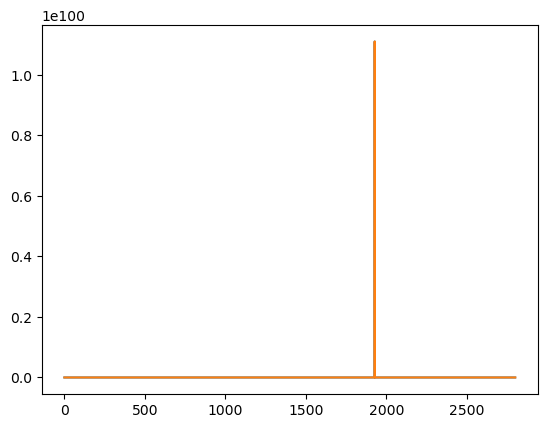

In [23]:
w2_unmatched_outcome = scipy.stats.norm.pdf(file_AB[file_AB.source_index_B==fixed_j].Y, mu2, np.sqrt(sigma2_square))

beta0 = beta0_k[-1]
beta1 = beta1_k[-1]
alpha = alpha_k[-1]

data_for_j = file_AB[file_AB.source_index_B==fixed_j].copy()
residuals = data_for_j.Y - np.array([data_for_j.intercept, data_for_j.propensity_score, data_for_j.propensity_score * data_for_j.treatment]).T @ np.array([beta0, beta1, alpha]).T
residuals_variance = residuals.T @ residuals / (len(residuals) - (3+1))

w2_matched_outcome = scipy.stats.norm.pdf(residuals, 0, np.sqrt(residuals_variance))

w2 = np.log(w2_matched_outcome/w2_unmatched_outcome)

probabilities = np.array(np.exp(w1+w2))

plt.plot(probabilities)

z = z_k[-1]
beta_pi = beta_pi_k[-1]
alpha_pi = alpha_pi_k[-1]
others = np.delete(z, fixed_j)
n_AB_ = (others>=0).sum()
file_A = A.copy()
file_B = B.copy()
proba_no_link = (file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
probabilities = np.append(probabilities, proba_no_link)

plt.plot(probabilities)

/var/folders/_7/32t15g3d2h54d0ct6cssb9gh0000gn/T/ipykernel_13840/261696753.py:15: RuntimeWarning: overflow encountered in exp
  plt.plot(np.exp(np.array(w1/w2)))


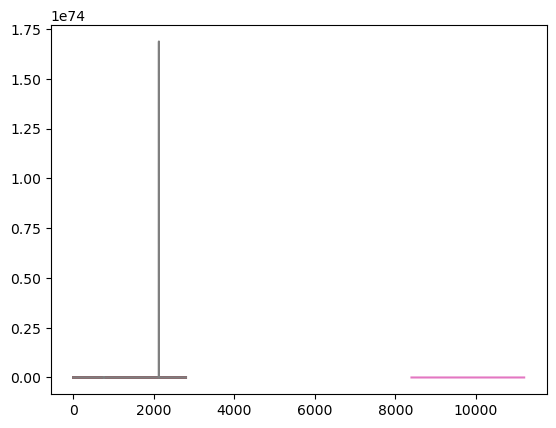

In [24]:
plt.plot(w2_unmatched_outcome)

plt.plot(np.array(w1))

plt.plot(w2)

plt.plot(w2_unmatched_outcome)

plt.plot(w2_matched_outcome)

plt.plot(np.log(w2_matched_outcome/w2_unmatched_outcome))

plt.plot(w1 + np.log(w2_matched_outcome/w2_unmatched_outcome))

plt.plot(np.exp(np.array(w1/w2)))